# Analysis I

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from datetime import datetime
import statsmodels.api as sm
from functools import reduce

In [2]:
from get_dataset import Finance
F = Finance()

In [3]:
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [4]:
# bring in the companies in S&P500
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


### Adjusted Close & Returns by Sector

In [5]:
sectors = F.get_sector()
sectors

['Industrials',
 'Health Care',
 'Information Technology',
 'Communication Services',
 'Consumer Staples',
 'Consumer Discretionary',
 'Utilities',
 'Financials',
 'Materials',
 'Real Estate',
 'Energy']

In [6]:
mean_returns = []
for ii, s in enumerate(sectors):
    df = F.concat_sector(s).reset_index()
    progress = f"sector {ii+1} of {len(sectors)}"
    print(progress, end='\r')
    mean_returns.append(df[['Date', 'Adj Close', 'Return']].groupby(['Date']).mean())
len(mean_returns)
mean_returns[0].head()

,Adj Close,Return
Date,,
2000-01-03,16.070021,NaN
2000-01-04,15.653115,-0.023812
2000-01-05,15.741684,0.007095
2000-01-06,15.979188,0.008933
2000-01-07,16.367253,0.021602


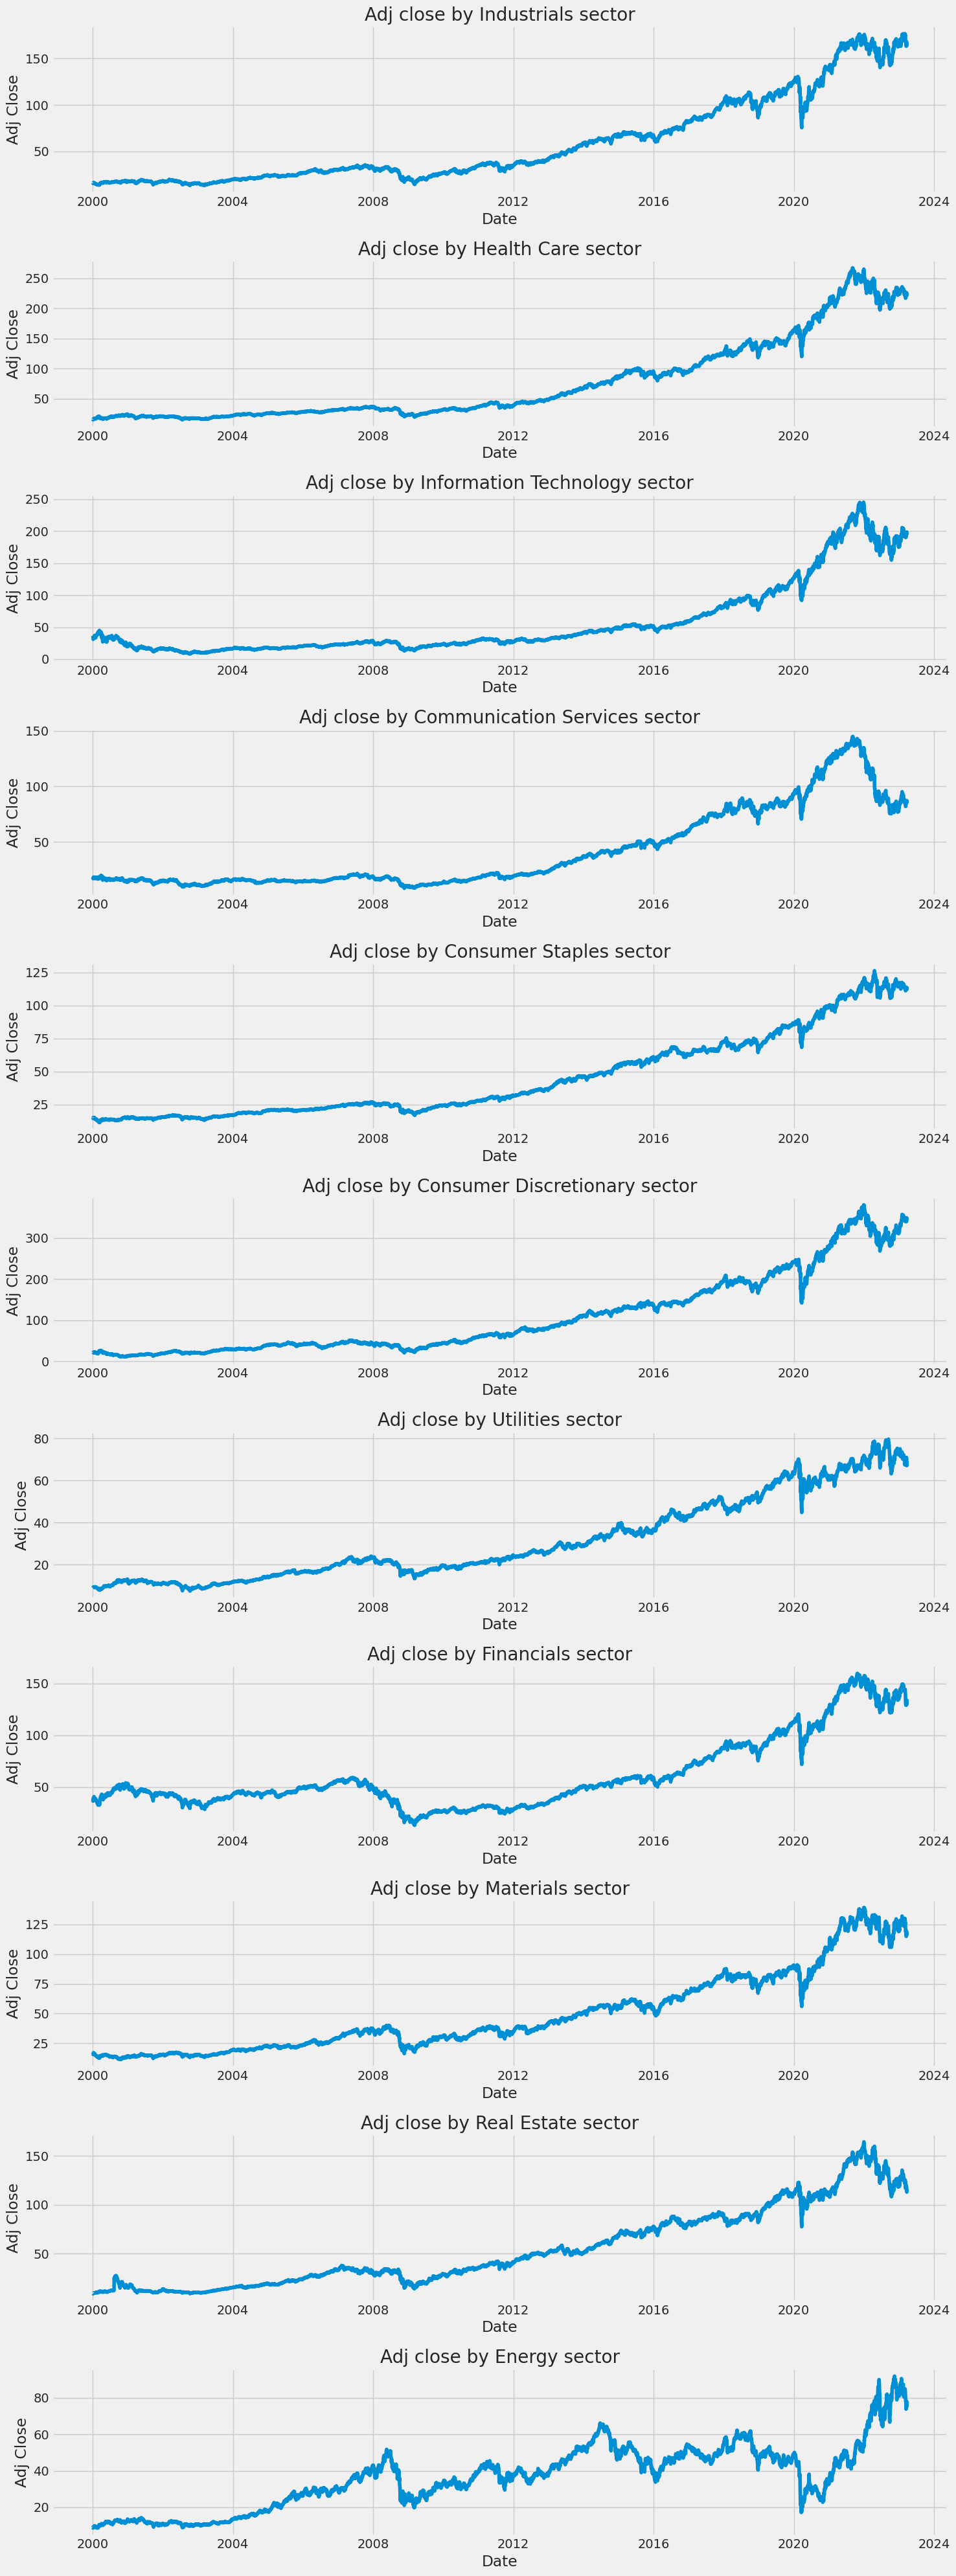

In [7]:
plt.figure(figsize=(15,40))
for ii, mr in enumerate(mean_returns):
    plt.subplot(len(mean_returns),1,ii+1)
    ax = sns.lineplot(x=mr.index, y=mr.iloc[:,0])
    ax.set_title('Adj close by '+str(sectors[ii])+' sector')
plt.tight_layout()
plt.show()

In [8]:
F.get_subindustry('Energy')

['Oil & Gas Exploration & Production',
 'Oil & Gas Equipment & Services',
 'Integrated Oil & Gas',
 'Oil & Gas Storage & Transportation',
 'Oil & Gas Refining & Marketing']

In [9]:
F.get_subindustry('Consumer Discretionary')

['Automotive Retail',
 'Internet & Direct Marketing Retail',
 'Automotive Parts & Equipment',
 'Specialty Stores',
 'Computer & Electronics Retail',
 'Casinos & Gaming',
 'Hotels, Resorts & Cruise Lines',
 'Restaurants',
 'Homebuilding',
 'Automobile Manufacturers',
 'Consumer Electronics',
 'Leisure Products',
 'Home Improvement Retail',
 'Distributors',
 'Home Furnishings',
 'Housewares & Specialties',
 'Apparel, Accessories & Luxury Goods',
 'Apparel Retail',
 'Household Appliances']

### Volatility by Sector

In [10]:
volatility, mean_ret = [], []
for mr in mean_returns:
    v = mr['Return'].std()
    m = mr['Return'].mean()
    mean_ret.append(m)
    volatility.append(v)
print(len(volatility))
print(len(mean_ret))

11
11


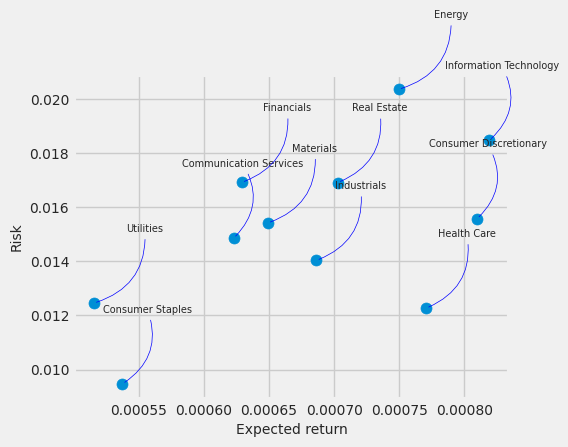

In [11]:
area = np.pi * 20

plt.figure(figsize=(5, 4))
plt.scatter(mean_ret, volatility, s=area)
plt.xlabel('Expected return', fontsize=10)
plt.ylabel('Risk', fontsize=10)

for label, x, y in zip(sectors, mean_ret, volatility):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', fontsize=7,
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.4'))
    
plt.tick_params(labelsize=10) 
plt.show()

In [12]:
window = 30
for mr in mean_returns:
    mr['Rolling_'+str(window)] = mr['Return'].rolling(window=30).mean()
mean_returns[0].head()

,Adj Close,Return,Rolling_30
Date,,,
2000-01-03,16.070021,NaN,NaN
2000-01-04,15.653115,-0.023812,NaN
2000-01-05,15.741684,0.007095,NaN
2000-01-06,15.979188,0.008933,NaN
2000-01-07,16.367253,0.021602,NaN


### Beta by Sector

In [13]:
global_market = pd.concat(mean_returns).drop(columns=['Rolling_30'])
global_market = global_market.reset_index()
global_market = global_market.groupby(['Date']).mean()
global_market.head()

,Adj Close,Return
Date,,
2000-01-03,18.435888,NaN
2000-01-04,17.858094,-0.024350
2000-01-05,17.999816,0.008527
2000-01-06,17.914913,0.007109
2000-01-07,18.498796,0.023866


In [14]:
merge = pd.merge(mean_returns[0].reset_index(), global_market.reset_index(), on='Date')
merge.head()

,Date,Adj Close_x,Return_x,Rolling_30,Adj Close_y,Return_y
0,2000-01-03,16.070021,NaN,NaN,18.435888,NaN
1,2000-01-04,15.653115,-0.023812,NaN,17.858094,-0.024350
2,2000-01-05,15.741684,0.007095,NaN,17.999816,0.008527
3,2000-01-06,15.979188,0.008933,NaN,17.914913,0.007109
4,2000-01-07,16.367253,0.021602,NaN,18.498796,0.023866


In [15]:
y = merge['Return_x'].dropna()
X = sm.add_constant(merge['Return_y'].dropna())
model = sm.OLS(y, X)
results = model.fit()
beta = results.params['Return_y']
beta

1.0383849752330645

In [16]:
beta = []
for mr in mean_returns:
    merge = pd.merge(mr.reset_index(), global_market.reset_index(), on='Date')
    y = merge['Return_x'].dropna()
    X = sm.add_constant(merge['Return_y'].dropna())
    model = sm.OLS(y, X)
    results = model.fit()
    beta.append(results.params['Return_y'])
beta

[1.0383849752330645,
 0.8207462812410704,
 1.1973758198060496,
 1.0157902235135923,
 0.5899401029884236,
 1.1057183897535554,
 0.6725649142666879,
 1.194901545354486,
 1.0883927011307644,
 1.0887504264008607,
 1.1874346203114425]

/tmp/ipykernel_6358/4230545140.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


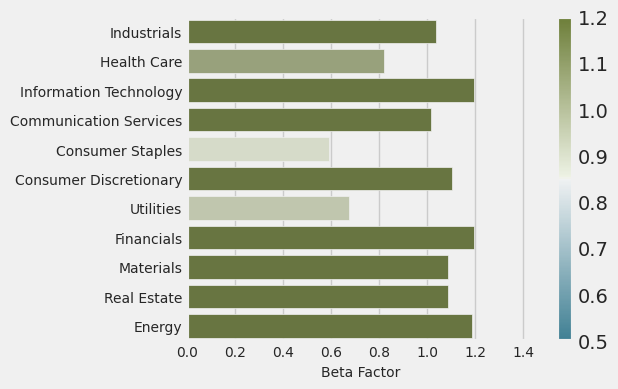

In [17]:
plt.figure(figsize=(5,4))
cmap = sns.diverging_palette(220, 100, as_cmap=True)
ax = sns.barplot(x=beta, y=sectors, palette=cmap(beta))
# ax.line(x=[1,1], y=)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0.5, vmax=1.2))
sm.set_array([])
cbar = plt.colorbar(sm)

plt.xlim([0, 1.45])
plt.xlabel('Beta Factor', fontsize=10)
plt.tick_params(labelsize=10)
# plt.xticks(rotation=90)
plt.show()

### Correlation

In [18]:
sectors = sectors + ['global']

df_adj = [mr[['Adj Close']].reset_index() for mr in mean_returns] + [global_market[['Adj Close']].reset_index()]
df_adj = [ mr.rename(columns={'Adj Close': 'Adj Close '+str(sectors[ii])}) for ii, mr in enumerate(df_adj)]
df_adj[0].head()

,Date,Adj Close Industrials
0,2000-01-03,16.070021
1,2000-01-04,15.653115
2,2000-01-05,15.741684
3,2000-01-06,15.979188
4,2000-01-07,16.367253


In [19]:
df_corr = reduce(lambda left, right: pd.merge(left, right, on='Date'), df_adj)
df_corr.drop(columns=['Date'], inplace=True)
df_corr.head()

,Adj Close Industrials,Adj Close Health Care,Adj Close Information Technology,Adj Close Communication Services,Adj Close Consumer Staples,Adj Close Consumer Discretionary,Adj Close Utilities,Adj Close Financials,Adj Close Materials,Adj Close Real Estate,Adj Close Energy,Adj Close global
0,16.070021,15.607121,36.355846,18.329889,14.836329,20.973335,8.873893,38.213338,15.788692,8.917900,8.828400,18.435888
1,15.653115,15.095999,34.345069,17.483529,14.464097,21.098528,8.918884,36.380378,15.481122,8.803615,8.714699,17.858094
2,15.741684,15.239841,33.676515,17.438849,14.413617,22.211030,9.235526,36.456243,15.966740,8.809423,8.808505,17.999816
3,15.979188,15.420837,31.049840,16.889654,14.577328,21.715032,9.259541,37.547449,16.484433,8.892340,9.248400,17.914913
4,16.367253,16.538767,32.423314,17.206016,15.170554,21.916650,9.372488,39.139862,16.734407,9.168433,9.449008,18.498796


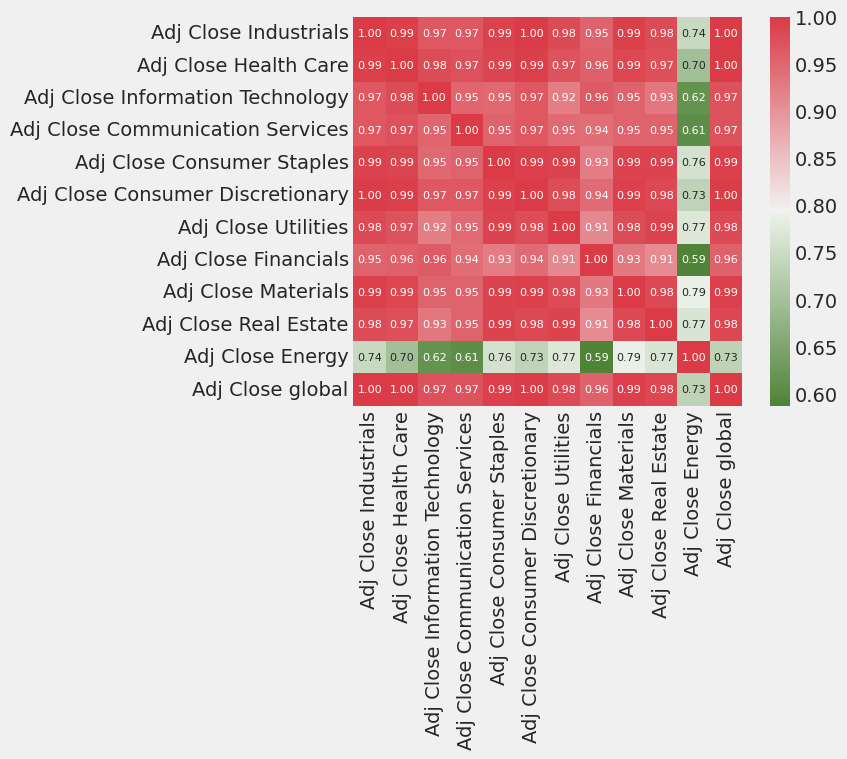

In [20]:
corr = df_corr.corr()
plt.figure()
sns.heatmap(corr, cbar = True, square = True, annot=True, fmt= '.2f',annot_kws={'fontsize': 8},
           xticklabels= df_corr.columns, 
           yticklabels= df_corr.columns,
           cmap=sns.diverging_palette(120, 10, as_cmap=True))
plt.show()